In [2]:
import json
import graphviz
import csv
import numpy as np
import tifffile

In [3]:
annotation_file_2017 = '/jukebox/LightSheetTransfer/atlas/allen_atlas/annotation_2017_25um_sagittal_forDVscans.nrrd'
csv_file = 'allen_id_table_w_voxel_counts.csv'

test_ontology_file = 'test_ontology.json'
with open(test_ontology_file) as json_file:
    test_data = json.load(json_file)
    
ontology_file = 'allen_ontology.json'
with open(ontology_file) as json_file:
    data = json.load(json_file)
    
atlas_segments_file = 'annotation_2017_25um_sagittal_forDVscans_segments.txt'
segments = np.loadtxt(atlas_segments_file,dtype='uint32')

displayed_atlas_regions_2017 = []
with open(csv_file, mode='r') as infile:
        reader = csv.reader(infile)
        next(reader) # skips the header
        for row in reader:
            ID,name = int(row[0]),row[1]
            if ID in segments:
                displayed_atlas_regions_2017.append(name)

## Purpose
This notebook is where I will try to make simpler annotation volumes of the Allen atlas using the ontology structure graph.

In [Ontology2dotfile.ipynb](Ontology2dotfile.ipynb), I figured out how to display a graph from the JSON format that the Allen atlas ontology uses. For example:

In [4]:
def make_graph(dic,graph):
    """ Make a edge-unweighted directed graph from a dictionary
    Representing a brain ontology
    """
    name = dic.get('name')
    label = name if len(name.split())<2 else '{0}\n{1}'.format(name.split()[0],' '.join(name.split()[1:])) # ternary operator 
    if name in displayed_atlas_regions_2017:
        graph.node(name,label,style='filled',fillcolor='yellow')
    else:
        graph.node(name,label)
    children = dic.get('children')
    for child in children:
        child_name = child.get('name')            
        graph.edge(name,child_name)
        make_graph(child,graph)
    return

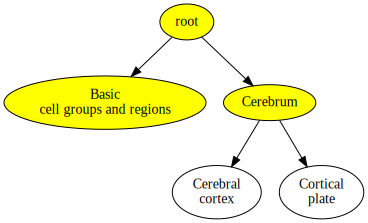

In [5]:
G = graphviz.Digraph()
make_graph(test_data,G)
G

In the graph diagram, the yellow nodes are the ones which are actually in the annotation volume. 

The goal is to pick a particular rank (say rank level 2 in this example) and collapse all segments in the volume into their parent at level 2. 

To do the collapsing, I want a dictionary where keys are parent ID and values are a list of all child IDs, e.g.:
```python
{5:[265,45,71],6:[234,89234]}
```
Then for each parent Id I can just loop through the list of children and change their IDs in the annotation volume to the parent ID. 

The question is: how to make these lists in the first place. Now that we have the graph, maybe there are some functions we can take advantage of. No, there are not: https://github.com/xflr6/graphviz/issues/19. graphviz and its python library are just for making the graph. So I will have to do this from the dictionary, which is fine.

## Basic example
OK, let's make a dummy annotation 3d atlas which contains the IDs  of the test dictionary

In [6]:
test_annotation_atlas = np.zeros((3,3,3))
test_annotation_atlas[0,1:3]=997
test_annotation_atlas[1,:,:]=567
test_annotation_atlas[1,0,:]=688
test_annotation_atlas[1,0,1]=695

In [7]:
test_annotation_atlas

array([[[  0.,   0.,   0.],
        [997., 997., 997.],
        [997., 997., 997.]],

       [[688., 695., 688.],
        [567., 567., 567.],
        [567., 567., 567.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]])

Now let's say that we want to collapse all ids that are children of 997 (all other ids except 0) to 997.

In [26]:
test_collapse_dict = {997:[567,688,695]}

In [28]:
child_ids = test_collapse_dict[997]
child_ids

[567, 688, 695]

In [35]:
%%time

# Is it faster to make a separate mask for each ID and apply it or to make a joint OR mask and then apply it once?
test_atlas_copy = test_annotation_atlas.copy()
# test_atlas_copy
for child_id in child_ids:
    mask = test_atlas_copy == child_id
    test_atlas_copy[mask]=997
# test_atlas_copy

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 88.2 µs


In [62]:
%%time

# Is it faster to make a separate mask for each ID and apply it or to make a joint OR mask and then apply it once?
test_atlas_copy = test_annotation_atlas.copy()
# list_of_mask_statements = ['test_atlas_copy == %i' % i for i in child_ids ]
# mask_statement = '(' + ' || '.join(list_of_mask_statements) + ')'
# mask_statement
for child_id in child_ids:
    mask = test_atlas_copy == child_id
    list_of_masks.append(mask)
combined_mask = np.logical_or.reduce(list_of_masks)
test_atlas_copy[combined_mask]=997

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 407 µs


In [68]:
%%time
test_atlas_copy = test_annotation_atlas.copy()
mask_list = [test_atlas_copy == child_id for child_id in child_ids]
combined_mask = np.logical_or.reduce(mask_list)

test_atlas_copy[combined_mask]=997
# test_atlas_copy
# for child_id in child_ids:
#     mask = test_atlas_copy == child_id
#     list_of_masks.append(mask)
# combined_mask = np.logical_or.reduce(list_of_masks)
# test_atlas_copy[combined_mask]=997
# test_atlas_copy

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 144 µs


<generator object <genexpr> at 0x7f7178aeaa20>

## Adding "rank" key to ontology dictionary

In [8]:
def add_rank_keys_to_ontology(ontology_dict,current_rank=0):
    """ Loop through an ontology dictionary and add a key which is the 
    current "level" in the graph. "st_level" already exists but it is not continuous
    between parent and child. 
    """
    name = ontology_dict.get('name')
    ID = ontology_dict.get('id')
    children = ontology_dict.get('children')
    ontology_dict['rank']=current_rank
    current_rank+=1
    
    for child in children:
        add_rank_keys_to_ontology(child,current_rank)            
        
    return

In [15]:
# First on test data
output_dict = test_data.copy()
add_rank_keys_to_ontology(output_dict)
output_dict

{'id': 997,
 'name': 'root',
 'acronym': 'root',
 'parent_structure_id': 'null',
 'st_level': 0,
 'graph_order': 0,
 'children': [{'id': 8,
   'name': 'Basic cell groups and regions',
   'acronym': 'Grey',
   'st_level': 1,
   'graph_order': 1,
   'parent_structure_id': 997,
   'children': [],
   'rank': 1},
  {'id': 567,
   'st_level': 2,
   'name': 'Cerebrum',
   'acronym': 'CH',
   'children': [{'id': 688,
     'name': 'Cerebral cortex',
     'atlas_id': 85,
     'ontology_id': 1,
     'graph_order': 3,
     'acronym': 'CTX',
     'color_hex_triplet': 'B0FFB8',
     'st_level': 3,
     'hemisphere_id': 3,
     'parent_structure_id': 567,
     'children': [],
     'rank': 2},
    {'id': 695,
     'atlas_id': 86,
     'ontology_id': 1,
     'acronym': 'CTXpl',
     'name': 'Cortical plate',
     'color_hex_triplet': '70FF70',
     'graph_order': 4,
     'st_level': 3,
     'hemisphere_id': 3,
     'parent_structure_id': 688,
     'children': [],
     'rank': 2}],
   'rank': 1}],
 'ran

In [16]:
# Check that it worked
output_dict['rank']

0

In [17]:
# Now on real data
ontology_dict_withrank = data.copy()
add_rank_keys_to_ontology(ontology_dict_withrank)
ontology_dict_withrank

{'id': 997,
 'atlas_id': -1,
 'ontology_id': 1,
 'acronym': 'root',
 'name': 'root',
 'color_hex_triplet': 'FFFFFF',
 'graph_order': 0,
 'st_level': 0,
 'hemisphere_id': 3,
 'parent_structure_id': None,
 'children': [{'id': 8,
   'atlas_id': 0,
   'ontology_id': 1,
   'acronym': 'grey',
   'name': 'Basic cell groups and regions',
   'color_hex_triplet': 'BFDAE3',
   'graph_order': 1,
   'st_level': 1,
   'hemisphere_id': 3,
   'parent_structure_id': 997,
   'children': [{'id': 567,
     'atlas_id': 70,
     'ontology_id': 1,
     'acronym': 'CH',
     'name': 'Cerebrum',
     'color_hex_triplet': 'B0F0FF',
     'graph_order': 2,
     'st_level': 2,
     'hemisphere_id': 3,
     'parent_structure_id': 8,
     'children': [{'id': 688,
       'atlas_id': 85,
       'ontology_id': 1,
       'acronym': 'CTX',
       'name': 'Cerebral cortex',
       'color_hex_triplet': 'B0FFB8',
       'graph_order': 3,
       'st_level': 3,
       'hemisphere_id': 3,
       'parent_structure_id': 567,
   

In [12]:
# Save new dict as JSON
import json

with open('allen_ontology_withrank.json', 'w') as fp:
    json.dump(ontology_dict_withrank, fp,indent=2)

## Make dictionary linking parents at a given rank to all their children

In [18]:
def make_collapse_dict_postranking(ontology_dict,collapse_rank,output_dict):
    """ Loop through an ontology dictionary and return a dictionary 
    whose keys are parent ids at the level of collapse_rank and values are a list
    of child ids. Here I operate on a new dictionary in which I have added the rank
    as a key to each region. "st_level" already existed but it is not continuous
    across the regions.
    """
    assert collapse_rank > 0, "You must use a collapse_rank > 0"
    name = ontology_dict.get('name')
    ID = ontology_dict.get('id')
    children = ontology_dict.get('children')
    graph_rank = ontology_dict.get('rank')

    if graph_rank == collapse_rank:
        output_dict[ID]=[]
        global current_parent
        current_parent = ID
#         print("current parent is:",current_parent)
    
#     print(ID,name,graph_rank,collapse_rank,output_dict)
    
#     print("looping through children")
    for child in children:
        child_ID = child.get('id')
        child_graph_rank = child.get('rank')
        if child_graph_rank > collapse_rank:
            output_dict[current_parent].append(child_ID)
        make_collapse_dict_postranking(child,collapse_rank,output_dict)
                
        
    return

In [21]:
# First on test data
id_dict = {}
make_collapse_dict_postranking(ontology_dict=test_data,collapse_rank=1,output_dict=id_dict)
id_dict

{8: [], 567: [688, 695]}

In [78]:
# Now real data
collapsed_id_dict = {}
make_collapse_dict_postranking(ontology_dict=ontology_dict_withrank,collapse_rank=3,output_dict=collapsed_id_dict)
collapsed_id_dict

{688: [695,
  315,
  184,
  68,
  667,
  526157192,
  526157196,
  526322264,
  500,
  107,
  219,
  299,
  644,
  947,
  985,
  320,
  943,
  648,
  844,
  882,
  993,
  656,
  962,
  767,
  1021,
  1085,
  453,
  12993,
  12994,
  12995,
  12996,
  12997,
  12998,
  322,
  793,
  346,
  865,
  921,
  686,
  719,
  353,
  558,
  838,
  654,
  702,
  889,
  929,
  329,
  981,
  201,
  1047,
  1070,
  1038,
  1062,
  480149202,
  480149206,
  480149210,
  480149214,
  480149218,
  480149222,
  480149226,
  337,
  1030,
  113,
  1094,
  1128,
  478,
  510,
  345,
  878,
  657,
  950,
  974,
  1102,
  2,
  369,
  450,
  854,
  577,
  625,
  945,
  1026,
  361,
  1006,
  670,
  1086,
  1111,
  9,
  461,
  182305689,
  182305693,
  182305697,
  182305701,
  182305705,
  182305709,
  182305713,
  378,
  873,
  806,
  1035,
  1090,
  862,
  893,
  1057,
  36,
  180,
  148,
  187,
  638,
  662,
  677,
  897,
  1106,
  1010,
  1058,
  857,
  849,
  247,
  1011,
  527,
  600,
  678,
  252,
  156

In [86]:
collapsed_id_dict.keys()

dict_keys([688, 623, 1129, 313, 1065, 528, 519, 885, 949, 840, 848, 832, 911, 710, 901, 798, 933, 808, 917, 717, 813, 925, 792, 871, 744, 752, 728, 776, 784, 896, 760, 877, 863, 736, 855, 941, 768, 824, 89, 98, 108, 116, 153, 1055, 1063, 1071, 1078, 1087, 1095, 1103, 1112, 1119, 3, 11, 18, 25, 34, 43, 49, 57, 65])

In [24]:
# OK, now go into the current annotation volume and assign each of the children IDs of each parent to the parent ID
annotation_vol = tifffile.imread(annotation_file_2017)

In [52]:
def collapse_annotation_forloop(annotation_volume,collapse_dict):
    """
    ---PURPOSE---
    Assign child ids to parent ids in collapse_dict within an annotation volume
    """
    for parent_id in collapse_dict.keys():
        child_ids = collapse_dict[parent_id]
        for child_id in child_ids:
            mask = annotation_volume == child_id
            annotation_volume[mask] = parent_id

In [69]:
def collapse_annotation_masklist(annotation_volume,collapse_dict):
    """
    ---PURPOSE---
    Assign child ids to parent ids in collapse_dict within an annotation volume
    """
    for parent_id in collapse_dict.keys():
        child_ids = collapse_dict[parent_id]
        mask_list = [annotation_volume == child_id for child_id in child_ids]
        combined_mask = np.logical_or.reduce(mask_list)
        annotation_volume[combined_mask] = parent_id

In [79]:
%%time
copied_vol = annotation_vol.copy()
collapse_annotation_forloop(copied_vol,collapse_dict=collapsed_id_dict)

CPU times: user 50.8 s, sys: 22.4 s, total: 1min 13s
Wall time: 1min 13s


In [76]:
%%time
test_dict = collapsed_id_dict
copied_vol = annotation_vol.copy()
collapse_annotation_masklist(copied_vol,collapse_dict=collapsed_id_dict)

CPU times: user 29.2 s, sys: 16.7 s, total: 45.9 s
Wall time: 45.9 s


The for loop method turns out to be about twice as fast as the masklist method, so let's stick with for loop. 

Test that it worked

In [80]:
681 in copied_vol

False

In [81]:
681 in annotation_vol

True

In [83]:
# Save the copied volume
tifffile.imwrite('annotation_2017_25um_sagittal_rank3.tif',copied_vol)

In [87]:
copied_vol.shape

(456, 528, 320)

In [91]:
segments=np.unique(copied_vol)

In [96]:
segments.astype('uint16')

array([    0,    81,    98,   108,   129,   140,   145,   153,   164,
         313,   512,   519,   528,   623,   688,   728,   744,   752,
         760,   768,   776,   784,   792,   798,   824,   832,   840,
         848,   863,   877,   896,   901,   911,   917,   933,   949,
         997,  1009,  1065,  1129, 50080, 50096, 44768, 44800, 44864,
       43744, 34176,  2656,  1120, 14144, 52160,  1216, 12288, 12096,
       12160, 38080, 28800, 28864, 22720, 54272], dtype=uint16)

In [97]:
image = np.array(tifffile.imread('annotation_2017_25um_sagittal_rank3.tif'),dtype=np.uint16, order='F')

In [99]:
segments=np.unique(image)

In [100]:
segments

array([    0,    81,    98,   108,   129,   140,   145,   153,   164,
         313,   512,   519,   528,   623,   688,   728,   744,   752,
         760,   768,   776,   784,   792,   798,   824,   832,   840,
         848,   863,   877,   896,   901,   911,   917,   933,   949,
         997,  1009,  1065,  1120,  1129,  1216,  2656, 12096, 12160,
       12288, 14144, 22720, 28800, 28864, 34176, 38080, 43744, 44768,
       44800, 44864, 50080, 50096, 52160, 54272], dtype=uint16)

In [101]:
len(segments)

60